In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.metrics import classification_report


In [103]:
dados = pd.read_excel("/content/drive/MyDrive/eleflow/dataset_netflix.xlsx")
dados.index = dados['title']
dados = dados.dropna(subset=['rating'])

#### Dividindo os dados em duas classes distintas

Julguei ser interessante criar dois modelos, um para filmes e outro para séries. Acredito que a vairável duração é muito significante para o modelo. Porém, a essa feature é medida de formas diferentes para séries e filmes. Sendo assim, necessitam de tratamentos diferentes. 

In [104]:
print(dados['type'].unique())
series = dados[dados['type'] == 'TV Show']
filmes = dados[dados['type'] == 'Movie']

['Movie' 'TV Show']


# 1 - Modelo para filmes

In [ ]:

filmes.dropna(subset=['duration'],inplace=True) #Existe uma única linha onde não há o valor de duração. Por isso reoslvi rmeovê-la. 
filmes['duration'] = pd.Series(filmes['duration'].str.split()).map(lambda x: int(x[0])).to_list() #Pegando o valor inteiro do tempo de duração dos filmes


#### Aplicando One-hot encoding (OHE) sobre os gêneros de filmes

In [106]:
generos = pd.Series(filmes['listed_in'].str.split(r'\, |&| '))
generos = pd.get_dummies(generos.apply(pd.Series).stack()).sum(level=0)
generos = generos.reindex(filmes.index)
generos_colunas = generos.columns
filmes = pd.concat([filmes, generos], axis=1)

#### Pegando os 20 atores mais frequentes e aplicando OHE sobre eles

In [107]:
atores = filmes.cast.str.split(r'\, |&').to_list()
filmes['cast'] = atores

In [108]:
filmes_exploded_atores = filmes.explode('cast')
atores_mais_frequentes = filmes_exploded_atores['cast'].value_counts()[:21].index.tolist()
atores_mais_frequentes.remove('bam')

def top_atores(atores):
    ator_list = []
    for ator in atores:
        if ator in atores_mais_frequentes:
            ator_list.append(ator)
    return ator_list

filmes['atores_frequentes'] = filmes['cast'].apply(lambda x: top_atores(x))
atores = pd.get_dummies(filmes['atores_frequentes'].apply(pd.Series).stack()).sum(level=0)
atores = atores.reindex(filmes.index)
atores.fillna(0,inplace=True)
aux = atores.sum(axis = 1, skipna = True)
filmes['atores'] = aux # Criando uma variável que compila quantos atores dos 20 mais frequentes está em cada filme


#### Pegando os 20 diretores mais frequentes e aplicando OHE sobre eles

In [109]:
diretores = filmes.director.str.split(r'\, |&').to_list()
filmes['director'] = diretores


In [110]:
filmes_exploded_diretores = filmes.explode('director')
diretores_mais_frequentes = filmes_exploded_diretores['director'].value_counts()[:20].index.tolist()
diretores_mais_frequentes

def top_diretores(diretores):
    diretor_list = []
    try:
      for diretor in diretores:
        if diretor in diretores_mais_frequentes:
            diretor_list.append(diretor)
    except:
      return diretor_list
    return diretor_list

filmes['diretores_frequentes'] = filmes['director'].apply(lambda x: top_diretores(x))
diretores = pd.get_dummies(filmes['diretores_frequentes'].apply(pd.Series).stack()).sum(level=0)
diretores = diretores.reindex(filmes.index)
diretores.fillna(0,inplace=True)
diretores_colunas = diretores.columns
filmes = pd.concat([filmes,diretores], axis=1)

### Validação

#### Análise determinística

Aplicando Holdout:

In [111]:
colunas = []
[colunas.append(i) for i in generos_colunas]
[colunas.append(i) for i in diretores_colunas]
colunas.append('atores')
colunas.append('duration')
colunas.append('release_year')



input, output = filmes[colunas], filmes['rating']
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3)

#Regressão Linear
lr = LinearRegression()
lr.fit(x_train, y_train)
print('R²: {}'.format(round(lr.score(x_test, y_test),2)))


# Florests Aleatória
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(x_train, y_train)

print('R²: {}'.format(round(regr.score(x_test, y_test),2)))

# Árvore de Decisão 
clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)
print('R²: {}'.format(round(clf.score(x_test, y_test),2)))


R²: 0.09
R²: 0.09
R²: -0.6


Aplicando validação cruzada:

In [112]:
print('R² regressão linear:',cross_val_score(lr, input, output, cv=5, scoring='r2'))
print('R² Floresta Aleatória:',cross_val_score(regr, input, output, cv=5, scoring='r2'))
print('R² Árvore de decisão:',cross_val_score(clf, input, output, cv=5, scoring='r2'))

R² regressão linear: [0.12471135 0.09092901 0.08152939 0.16128954 0.13938408]
R² Floresta Aleatória: [0.10334688 0.10172848 0.09182711 0.11452366 0.12922567]
R² Árvore de decisão: [-0.5541562  -0.8036025  -0.8273884  -0.71131311 -0.58120783]


Analisando a importância de cada feature aplicada ao modelo para saber se alguma deve ser excluída.

Text(0.5, 1.0, 'Importância de cada feature - Árvore de decisão')

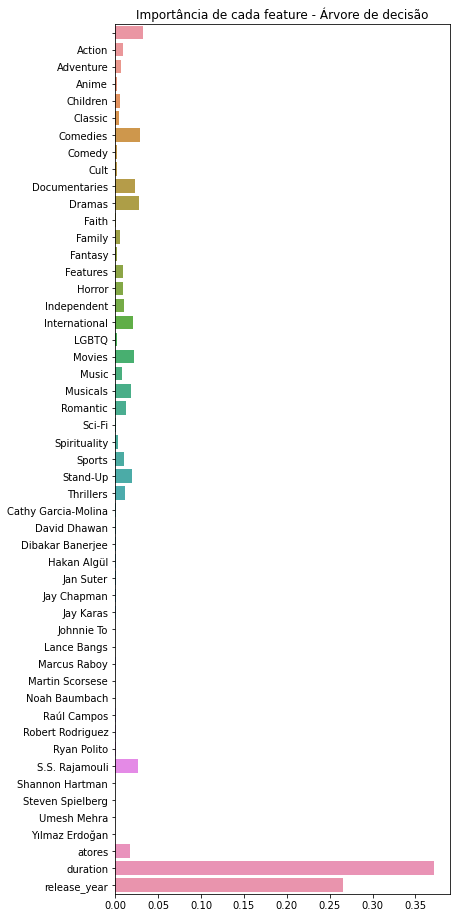

In [37]:
importances = pd.Series(data=clf.feature_importances_, index=colunas)
plt.figure(figsize=(6, 16))
sns.barplot(x=importances, y=importances.index).set_title('Importância de cada feature - Árvore de decisão')

É visível que os diretores não exercem qualquer influência geral sobre o modelo. A feature **atores** exerce inflência mínima e por isso será retirada do modelo junto das features de diretores.

Analisando o desemepnho do modelo sem essas features:

In [113]:
colunas = []
[colunas.append(i) for i in generos_colunas]
#colunas.append('atores')
colunas.append('duration')
colunas.append('release_year')

input, output = filmes[colunas], filmes['rating']
print(cross_val_score(clf, input, output, cv=5, scoring='r2'))

[-0.52122299 -0.73234942 -0.70261432 -0.60096036 -0.55804904]


A inflûencia de cada gênero individual é pequena, porém, unidos são responsáveis por quase metade da destreza de previsão do modelo. 

Desempenho do modelo sem essas features:

In [114]:
colunas = []
colunas.append('duration')
colunas.append('release_year')

input, output = filmes[colunas], filmes['rating']
print(cross_val_score(clf, input, output, cv=5, scoring='r2'))

[-0.34937539 -0.45741095 -0.50007667 -0.2958888  -0.31815344]


Tendo escolhido as features que vão integrar o modelo, partimos para a análise de dispersão:

Text(0.5, 1.0, 'Árvore de decisão vs. Nota do filme')

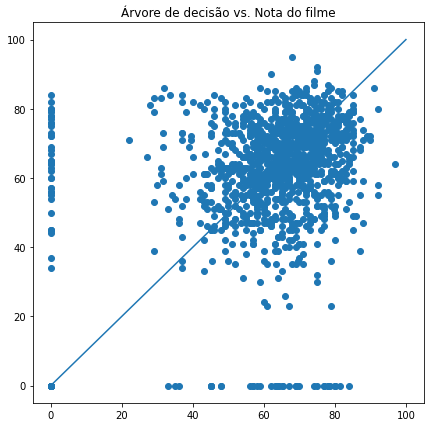

In [120]:
colunas = []
[colunas.append(i) for i in generos_colunas]
#colunas.append('atores')
colunas.append('duration')
colunas.append('release_year')

input, output = filmes[colunas], filmes['rating']
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3)

clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)

previsto = clf.predict(x_test)

plt.figure(figsize=(7, 7))
plt.scatter(previsto,y_test)
plt.plot(np.linspace(0,100), np.linspace(0,100))
plt.title('Árvore de decisão vs. Nota do filme')


Em análise visual o modelo parece ter atingido um desempenho razoável. Porém, há valores expúrios que ocorrem devido as notas 0 contidas na base de dados. 

Vamos excluir os valores 0 da base:

Score médio: -0.609


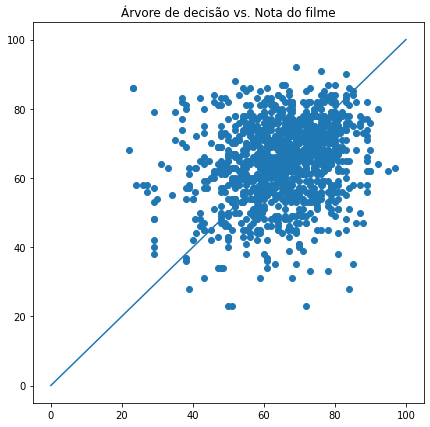

In [122]:

filmes_sem_nota0 = filmes[filmes['rating'] != 0]

input, output = filmes_sem_nota0[colunas], filmes_sem_nota0['rating']
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3)

clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)

previsto = clf.predict(x_test)

plt.figure(figsize=(7, 7))
plt.scatter(previsto,y_test)
plt.plot(np.linspace(0,100), np.linspace(0,100))
plt.title('Árvore de decisão vs. Nota do filme')

scores = cross_val_score(clf, input, output, cv=5, scoring='r2')
print('Score médio: {}'.format(round(scores.mean(),3)))


Análise de resíduos:

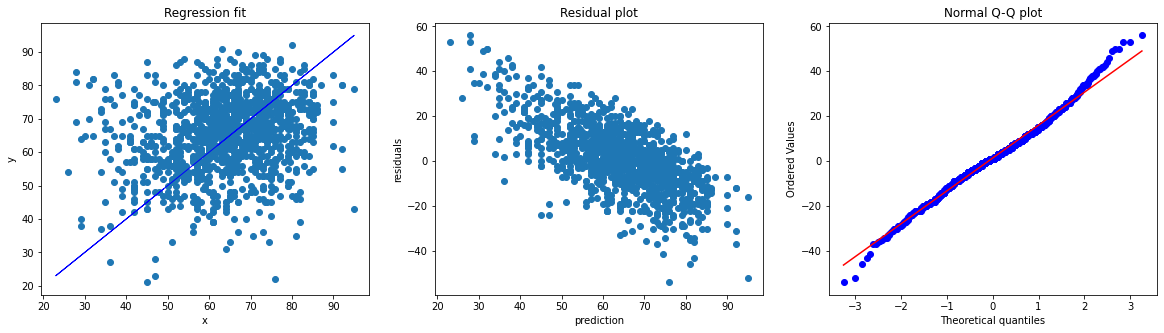

In [42]:
# Função para auxiliar a análise dos resíduos
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

diagnostic_plot(previsto,y_test)

Os resíduos do modelo se ajustam bem a normalidade, exceto nas bordas da distribuição. Mas até mesmo nas bordas, considerando uma aproximação, os resíduos parecem satisfazer a hipótese de normalidade.

#### Análise de classificação

Aplicai um método de classiificação simples para avaliar o desempenho do modelo em prever notas baixas ou altas. Notas abaixo de 60 são consideradas notas "ruins" ou "baixas" e igual ou acima disso a nota é considerada "boa" ou "alta". Esse método será aplicado também ao modelo de séries.

Calculando métricas a partir da matriz de confusão:

In [63]:
limiar = 60

filmes_sem_nota0 = filmes[filmes['rating'] != 0]
filmes_sem_nota0['classificação'] = [1 if nota >= limiar else 0 for nota in filmes_sem_nota0['rating'].to_list()]

input, output = filmes_sem_nota0[colunas], filmes_sem_nota0['rating']
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3)

clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)

previsto = clf.predict(x_test)

prev_classificado = [1 if nota >= limiar else 0 for nota in list(previsto)]
obs_classificado = [1 if nota >= limiar else 0 for nota in y_test]
target_names = ['Ruim', 'Bom']
print(classification_report(obs_classificado, prev_classificado, target_names=target_names))



              precision    recall  f1-score   support

        Ruim       0.40      0.38      0.39       344
         Bom       0.76      0.78      0.77       882

    accuracy                           0.67      1226
   macro avg       0.58      0.58      0.58      1226
weighted avg       0.66      0.67      0.66      1226



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Analisando as métricas acima. nota-se que para notas altas o modelo apresenta boa destreza. Por outro lado, a destreza do modelo em prever as notas baixas (abaixo de 60) é consideravelmente inferior. A métricas abaixo com valores abaixo de 0.5, considerando previsões binárias (Bom ou ruim), apontam que o modelo não é indicado para fazer esse tipo de previsão.

# 2 - Modelo para séries

In [123]:
series['seasons'] = pd.Series(series['duration'].str.split()).map(lambda x: int(x[0])).to_list() #Pegando o valor inteiro de temporadas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Aplicando One-hot encoding (OHE) sobre os gêneros de séries

In [124]:
generos = pd.Series(series['listed_in'].str.split(r'\, |&| '))
generos = pd.get_dummies(generos.apply(pd.Series).stack()).sum(level=0)
generos = generos.reindex(series.index)
generos_colunas = generos.columns
series = pd.concat([series, generos], axis=1)

#### Pegando os 20 atores mais frequentes e aplicando OHE sobre eles

In [125]:
atores = series.cast.str.split(r'\, |&').to_list()
series['cast'] = atores

In [126]:
series_exploded_atores = series.explode('cast')
atores_mais_frequentes = series_exploded_atores['cast'].value_counts()[:21].index.tolist()
atores_mais_frequentes.remove('bam')

def top_atores(atores):
    ator_list = []
    for ator in atores:
        if ator in atores_mais_frequentes:
            ator_list.append(ator)
    return ator_list

series['atores_frequentes'] = series['cast'].apply(lambda x: top_atores(x))
atores = pd.get_dummies(series['atores_frequentes'].apply(pd.Series).stack()).sum(level=0)
atores = atores.reindex(series.index)
atores.fillna(0,inplace=True)
aux = atores.sum(axis = 1, skipna = True)
series['atores'] = aux # Criando uma variável que compila quantos atores dos 20 mais frequentes está em cada séries

#### Pegando os 20 diretores mais frequentes e aplicando OHE sobre eles

In [127]:
diretores = series.director.str.split(r'\, |&').to_list()
series['director'] = diretores

In [128]:
series_exploded_diretores = series.explode('director')
diretores_mais_frequentes = series_exploded_diretores['director'].value_counts()[:20].index.tolist()
diretores_mais_frequentes

def top_diretores(diretores):
    diretor_list = []
    try:
      for diretor in diretores:
        if diretor in diretores_mais_frequentes:
            diretor_list.append(diretor)
    except:
      return diretor_list
    return diretor_list

series['diretores_frequentes'] = series['director'].apply(lambda x: top_diretores(x))
diretores = pd.get_dummies(series['diretores_frequentes'].apply(pd.Series).stack()).sum(level=0)
diretores = diretores.reindex(series.index)
diretores.fillna(0,inplace=True)
diretores_colunas = diretores.columns
series = pd.concat([series,diretores], axis=1)

### Validação 

#### Análise determinística

Aplicando Holdout:

In [70]:
colunas = []
[colunas.append(i) for i in generos_colunas]
[colunas.append(i) for i in diretores_colunas]
colunas.append('atores')
colunas.append('seasons')
colunas.append('release_year')



input, output = series[colunas], series['rating']
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3)

#Regressão Linear
lr = LinearRegression()
lr.fit(x_train, y_train)
print('R²: {}'.format(round(lr.score(x_test, y_test),2)))


# Florests ALeatória
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(x_train, y_train)

print('R²: {}'.format(round(regr.score(x_test, y_test),2)))

# Árvore de decisão 
clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)
print('R²: {}'.format(round(clf.score(x_test, y_test),2)))

R²: -3891977537617917.0
R²: 0.07
R²: -0.26


Aplicando validação cruzada

In [129]:
print('R² Regressão Linear',cross_val_score(lr, input, output, cv=5, scoring='r2'))
print('R² Floresta Aleatória',cross_val_score(regr, input, output, cv=5, scoring='r2'))
print('R² Árvore de decisão',cross_val_score(clf, input, output, cv=5, scoring='r2'))

R² Regressão Linear [0.18602805 0.12581072 0.16421767 0.22581419 0.16079891]
R² Floresta Aleatória [0.15903501 0.15300032 0.2053707  0.19997815 0.19896056]
R² Árvore de decisão [-0.74281293 -0.61295156 -0.64463862 -0.55111295 -0.53553638]


Mais uma vez o modelo Árvore de decisão se saiu melhor que os outros. Por isso, novamente, será o modelo analisado daqui pra frente.

Analisando a importância de cada feature aplicada ao modelo para saber se alguma deve ser excluída.


Text(0.5, 1.0, 'Importância de cada feature - Árvore de decisão')

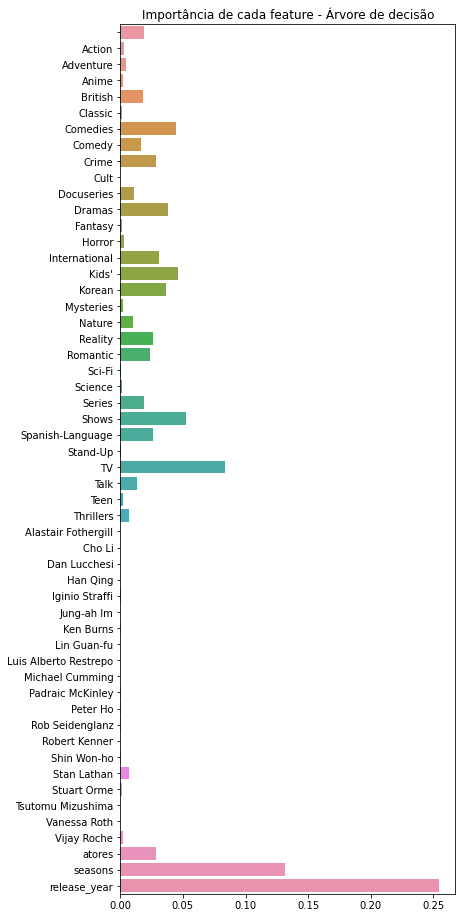

In [72]:
importances = pd.Series(data=clf.feature_importances_, index=colunas)
plt.figure(figsize=(6, 16))
sns.barplot(x=importances, y=importances.index).set_title('Importância de cada feature - Árvore de decisão')

Diferente do modelo para filmes, a duração das séries (que é aqui representada por **seasons**) não é a variável mais significante. Por outro lado, os gêneros das séries passam agora a ter um papael maior sobre a destreza do modelo. Novamente os diretores apresentam nenhuma significãncia e por isso serão excluídos. 

Dispersão final sem considerar os diretores, atores e excluindo notas 0:

Score médio: -0.483


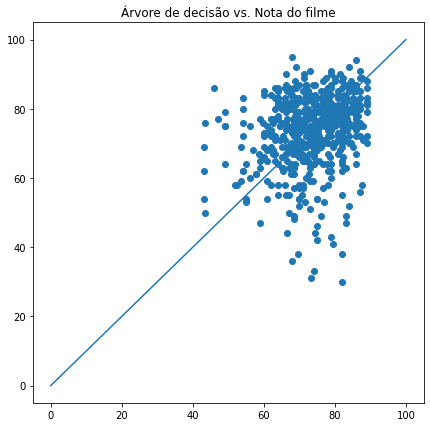

In [135]:
colunas = []
[colunas.append(i) for i in generos_colunas]
colunas.append('seasons')
colunas.append('release_year')


series_sem_nota0 = series[series['rating'] != 0]

input, output = series_sem_nota0[colunas], series_sem_nota0['rating']
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3)

clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)

previsto = clf.predict(x_test)

plt.figure(figsize=(7, 7))
plt.scatter(previsto,y_test)
plt.plot(np.linspace(0,100), np.linspace(0,100))
plt.title('Árvore de decisão vs. Nota do filme')

scores = cross_val_score(clf, input, output, cv=5, scoring='r2')
print('Score médio: {}'.format(round(scores.mean(),3)))

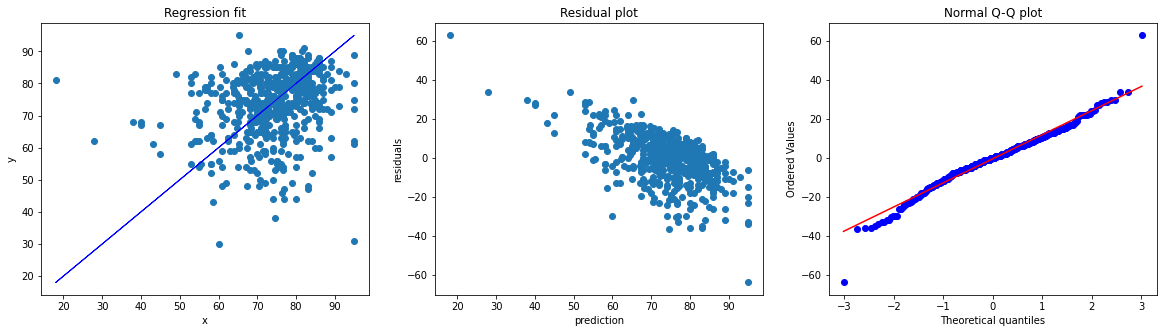

In [78]:
# Função para auxiliar a análise dos resíduos
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

diagnostic_plot(previsto,y_test)

A normalidade dos resíduos do modelo para séries parece razoável. Na borda inferior há um disanciamento, mas ainda está próximo da linha. Por aproximação, os resíduos são normalmente distribuídos. 

#### Análise de classificação

Calculando métricas a partir da matriz de confusão:

In [79]:
limiar = 60

series_sem_nota0 = series[series['rating'] != 0]
series_sem_nota0['classificação'] = [1 if nota >= limiar else 0 for nota in series_sem_nota0['rating'].to_list()]

input, output = series_sem_nota0[colunas], series_sem_nota0['rating']
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3)

clf = DecisionTreeRegressor()
clf.fit(x_train, y_train)

previsto = clf.predict(x_test)

prev_classificado = [1 if nota >= limiar else 0 for nota in list(previsto)]
obs_classificado = [1 if nota >= limiar else 0 for nota in y_test]
target_names = ['Ruim', 'Bom']
print(classification_report(obs_classificado, prev_classificado, target_names=target_names))

              precision    recall  f1-score   support

        Ruim       0.20      0.20      0.20        45
         Bom       0.93      0.93      0.93       501

    accuracy                           0.87       546
   macro avg       0.56      0.56      0.56       546
weighted avg       0.87      0.87      0.87       546



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Semelhante ao modelo para filmes, o modelo para séries apresenta ótima destreza para prever notas altas. Porém, as métricas do modelo para prever notas baixa continua inferior a 0.5, indicando que o modelo não é indicado para esse tipo de classficação. 

# Conclusões:

- Dos três modelos testados (Regressão linear, árvore de decisão e floresta aleatória), o algoritmo árvore de decisão obteve o melhor desempenho. O melhor desempenho deste modleo se deve, provavelmente, por ele lidar melhor com o número mais alto de features. Principalmente por que a maioria das features são binárias (Gênero).

- De forma geral o modelo apresentou boa destreza em prever determinísticamente as notas de filmes e séries. As métricas do modelo para filmes foram melhores que as métricas para o modelo de séries. O número de dados para séries é 4 vezes menor que o de dados para filmes. Além disso, a feature de **duração** de séries (número de temporadas) é mais ambígua que a mesma feature para filmes (duração do filme em minutos). Esses fatores provavelmente refletem a menor destreza do modelo para séries. 

- Considerando a nota limiar 60 para classficar filmes com notas baixas e altas, ambos os modelo mostram desempenho bom para notas consideradas altas. No tocante a notas baixas, ambos os modelos apresentam valores de precisão, recall e f-score abaixo de 0.5. De forma simples, signfica que o modelo não tem menos poder de previsão de notas baixas do que um simples processo estocástico aleatório (Cara ou coroa).


# Sugestões de melhorias do modelo:

- Na base de dados há a feature **description** que não foi explorada aqui por necessitar de uma análise e processamento mais robusto. Sugiro explorar mais essa feature para extrair informações mais relevantes ao modelo. 

- Outra feature não explorada nesta análise foi a de países. A feature diz respeito ao(s) país(es) ou continente(s) que a série ou filme foi ao ar. Desta forma pode haver relações significantes entre o país ou região lançada e outra feature do modelo, de forma que seja possível extrair uma nova feature derivada. Para exemplicar, suponhamos que filmes do gênero asiático não sejam bem aceitos no EUA. É essa relação hipotética pode dar ao modelo mais poder de estimar a nota do filme.

- A feature duração da base referente a séries pode ser melhorada. Medir a duração somente por temporada não é o ideal, dado que saber o número de episódios por temporada e a duração de cada epsódio pode melhorar bastante o modelo.

- Para classificar séries e filmes entre "bom" e "ruim" foi utilizado uma simplicação baseado numa nota de limiar. Pode-se avançar mais nessa análise de classificação. A princípio, definir com mais rigor essa nota limiar pode aumentar o desemepnho do modelo (principalmente para séries) em prever notas mais baixas. A definição do que é nota baixa e nota alta nesta análise foi completamente subjetiva. Neste caso, proponho que seja aplicado um método sbjetivo. Outra opção mais elaborada é classificar em categorias mais distintas. Com categorias mais distintas, seria possível não só avaliar a regressão do modelo de árvore de decisão, como avaliar o desempenho de modelos de classificação. 

